# Pandana Network Analysis Tutorial

This notebook demonstrates network accessibility analysis using Pandana with only `pandana`, `numpy`, `pandas`, and `warnings` libraries.

Based on the official Pandana tutorial workflow: [Pandana Tutorial](https://udst.github.io/pandana/tutorial.html), [Pandana Network Methods](https://udst.github.io/pandana/network.html)
1. Create the network
2. Precompute network distances
3. Nearest POI queries
4. Aggregation queries
5. Visualize results using Pandana's built-in plot method

## Imports

In [1]:
import pandas as pd
import pandana as pdna
from pandana.loaders import osm
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

print(f"Pandana version: {pdna.__version__}")


Pandana version: 0.7


## 1. Create the Network

Download street network from OpenStreetMap for Copenhagen area using Pandana's OSM loader.

In [2]:
# Format: (lng_min, lat_min, lng_max, lat_max)
bbox = (12.08625, 55.73939, 12.14461, 55.78072)

# Load network using pandana's OSM loader
# Note: lat/lng order is different for the function
network = osm.pdna_network_from_bbox(
    lat_min=bbox[1],  # 55.73939
    lng_min=bbox[0],  # 12.08625
    lat_max=bbox[3],  # 55.78072
    lng_max=bbox[2],  # 12.14461
    network_type='walk'  # Options: 'walk', 'drive', 'bike', 'drive_service', 'all'
)

print(f"Network loaded with {len(network.nodes_df)} nodes and {len(network.edges_df)} edges")

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](55.73939000,12.08625000,55.78072000,12.14461000);>;);out;'}"
Downloaded 0.7KB from www.overpass-api.de in 5.57 seconds
Unrecognized server status: "Rate limit: 4"
Server at www.overpass-api.de returned status code 504 and no JSON data. Re-trying request in 10.00 seconds.
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](55.73939000,12.08625000,55.78072000,12.14461000);>;);out;'}"
Downloaded 926.5KB from www.overpass-api.de in 0.68 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 requ

### Examine Network Structure

Nodes have x, y coordinates and edges connect nodes with weights (distances).

In [15]:
# View nodes structure
print("Nodes DataFrame:")
print(network.nodes_df.head(3))
print(f"\nTotal nodes: {len(network.nodes_df)}")

Nodes DataFrame:
                  x          y
id                            
26386326  12.128435  55.743719
26386329  12.128346  55.744122
26386492  12.125881  55.749806

Total nodes: 1814


In [16]:
# View edges structure
print("Edges DataFrame:")
print(network.edges_df.head(3))
print(f"\nTotal edges: {len(network.edges_df)}")

Edges DataFrame:
                             from          to    distance
26386983   7470495305    26386983  7470495305   69.379116
7470495305 7470491360  7470495305  7470491360   41.013058
7470491360 26386978    7470491360    26386978  460.518386

Total edges: 2450


## 2. Precompute Network Distances

**This is critical for performance!** Precomputing creates routing tables for fast queries.

In [17]:
%%time
# Precompute network within 3000 meters
print("Precomputing network distances up to 3000 meters...")
network.precompute(3000)
print("Precomputation complete!")

Precomputing network distances up to 3000 meters...
Precomputation complete!
CPU times: total: 328 ms
Wall time: 34 ms


## 3. Nearest POI Queries (With fake restaurants)

Find the nearest points of interest (e.g., restaurants) from any location in the network.

In [18]:
# Create synthetic restaurant locations for demonstration
num_restaurants = 50
nodes = network.nodes_df

# Sample random nodes as restaurant locations
np.random.seed(42)  # For reproducibility
restaurant_indices = np.random.choice(nodes.index, num_restaurants, replace=False)
restaurant_x = nodes.loc[restaurant_indices, 'x'].values
restaurant_y = nodes.loc[restaurant_indices, 'y'].values

print(f"{num_restaurants} restaurants created at random locations")
print(f"Sample coordinates: {list(zip(restaurant_x[:3], restaurant_y[:3]))}")

50 restaurants created at random locations
Sample coordinates: [(12.1031968, 55.764441), (12.1392193, 55.7636338), (12.0974693, 55.7698725)]


In [19]:
# Initialize the POI category
network.set_pois(
    category="restaurants",
    maxdist=2000,      # maximum distance in meters
    maxitems=10,       # find up to 10 nearest
    x_col=restaurant_x,
    y_col=restaurant_y
)

print("POI category 'restaurants' initialised")

POI category 'restaurants' initialised


In [20]:
%%time
# Perform nearest POI query
print("Finding 10 nearest restaurants for all nodes...")
nearest_restaurants = network.nearest_pois(
    distance=2000,
    category="restaurants",
    num_pois=10
)

print(f"\nQuery returned DataFrame with shape: {nearest_restaurants.shape}")
print(f"Columns represent 1st, 2nd, 3rd... nearest restaurant distances")

Finding 10 nearest restaurants for all nodes...

Query returned DataFrame with shape: (1814, 10)
Columns represent 1st, 2nd, 3rd... nearest restaurant distances
CPU times: total: 62.5 ms
Wall time: 16 ms


In [21]:
# View results statistics
print("Nearest restaurants query results (distances in meters):")
print(nearest_restaurants.describe())

Nearest restaurants query results (distances in meters):
                1            2            3            4            5   \
count  1814.000000  1814.000000  1814.000000  1814.000000  1814.000000   
mean    270.028673   479.087076   619.140970   721.585104   817.230670   
std     210.058841   289.663495   325.673193   349.062400   361.432672   
min       0.000000    18.724001    72.913002   163.436996   209.104996   
25%     118.312748   292.170746   401.887001   475.492500   543.268524   
50%     232.118500   411.959503   563.350494   651.821991   772.492523   
75%     372.039757   583.719254   747.034988   858.832016  1001.621017   
max    1356.649048  1738.046021  2000.000000  2000.000000  2000.000000   

                6            7            8            9            10  
count  1814.000000  1814.000000  1814.000000  1814.000000  1814.000000  
mean    884.577790   981.450612  1062.924205  1152.808099  1222.379081  
std     352.380276   371.505330   381.359515   404.717194

## 4. Aggregation Queries

Aggregate variables (like building square footage or population) within network distances.

In [10]:
# Create synthetic building data
num_buildings = 200
np.random.seed(42)
building_indices = np.random.choice(nodes.index, num_buildings, replace=False)

buildings = pd.DataFrame({
    'x': nodes.loc[building_indices, 'x'].values,
    'y': nodes.loc[building_indices, 'y'].values,
    'square_meter': np.random.randint(500, 5000, num_buildings),
    'residential_units': np.random.randint(1, 50, num_buildings)
})

print(f"{num_buildings} buildings created")
print("\nSample building data:")
print(buildings.head())

200 buildings created

Sample building data:
           x          y  square_meter  residential_units
0  12.103197  55.764441           605                  2
1  12.139219  55.763634          1386                  6
2  12.097469  55.769872           927                  9
3  12.112478  55.756915          2395                 33
4  12.098127  55.745757           816                 41


In [11]:
# Map building coordinates to nearest network nodes
buildings['node_ids'] = network.get_node_ids(buildings.x, buildings.y)

print("Buildings mapped to network nodes")
print(f"Sample node IDs: {buildings.node_ids.head().tolist()}")

Buildings mapped to network nodes
Sample node IDs: [3877684922, 8223905321, 1274086584, 2485455942, 3530660229]


In [12]:
# Set variables on the network
network.set(
    buildings.node_ids,
    variable=buildings.square_meter,
    name="square_meter"
)

network.set(
    buildings.node_ids,
    variable=buildings.residential_units,
    name="residential_units"
)

print("Variables assigned to network nodes:")
print("  - square_meter")
print("  - residential_units")

Variables assigned to network nodes:
  - square_meter
  - residential_units


### Perform Aggregations at Multiple Distances

In [24]:
%%time
# Aggregate square footage at different distances
print("Performing aggregations at multiple distances...")

sqft_500m = network.aggregate(500, type="sum", decay="linear", name="square_meter")
sqft_1000m = network.aggregate(1000, type="sum", decay="linear", name="square_meter")
sqft_2000m = network.aggregate(2000, type="sum", decay="linear", name="square_meter")
sqft_3000m = network.aggregate(3000, type="sum", decay="linear", name="square_meter")


# Average residential units
units_avg = network.aggregate(3000, type="ave", decay="flat", name="residential_units")

print("Aggregations complete!")

Performing aggregations at multiple distances...
Aggregations complete!
CPU times: total: 141 ms
Wall time: 22.9 ms


In [25]:
# View aggregation results
print("Square footage within 500m - Statistics:")
print(sqft_500m.describe())

Square footage within 500m - Statistics:
count     1814.000000
mean     23230.629242
std      20055.013275
min          0.000000
25%       8241.181038
50%      17240.434471
75%      32712.441404
max      89100.128553
dtype: float64


In [26]:
print("Square footage within 3000m - Statistics:")
print(sqft_3000m.describe())

Square footage within 3000m - Statistics:
count      1814.000000
mean     369227.448183
std      139866.572214
min       35953.158372
25%      244365.347028
50%      416723.119290
75%      492487.408014
max      570837.910879
dtype: float64


In [27]:
print("Average residential units within 3000m - Statistics:")
print(units_avg.describe())

Average residential units within 3000m - Statistics:
count    1814.000000
mean       25.003732
std         0.451160
min        22.538462
25%        24.776891
50%        24.985755
75%        25.210191
max        27.263889
dtype: float64


### Compare Aggregations Across Distances

In [28]:
# Create summary table
summary = pd.DataFrame({
    '500m': sqft_500m.describe(),
    '1000m': sqft_1000m.describe(),
    '2000m': sqft_2000m.describe(),
    '3000m': sqft_3000m.describe()
})

print("Square Footage Aggregation by Distance:")
print(summary)

Square Footage Aggregation by Distance:
               500m          1000m          2000m          3000m
count   1814.000000    1814.000000    1814.000000    1814.000000
mean   23230.629242   72066.123905  213997.304780  369227.448183
std    20055.013275   50136.110351  111188.563785  139866.572214
min        0.000000       0.000000    3938.223940   35953.158372
25%     8241.181038   31911.548111  103201.701566  244365.347028
50%    17240.434471   55050.051065  216984.995504  416723.119290
75%    32712.441404  106313.695059  318818.424147  492487.408014
max    89100.128553  190836.628362  413351.344697  570837.910879


## 5. Display Results using Pandana's Built-in Plot Method

Pandana provides an experimental `plot()` method for displaying node values using matplotlib.

**Note:** Using bounding boxes helps reduce the number of points shown for better visualization performance.

In [29]:
# Define bounding box for Copenhagen visualization
# Format: [lat_min, lng_min, lat_max, lng_max]
copenhagen_bbox = [55.73939, 12.08625, 55.78072, 12.14461]

### Distance to Nearest Restaurant

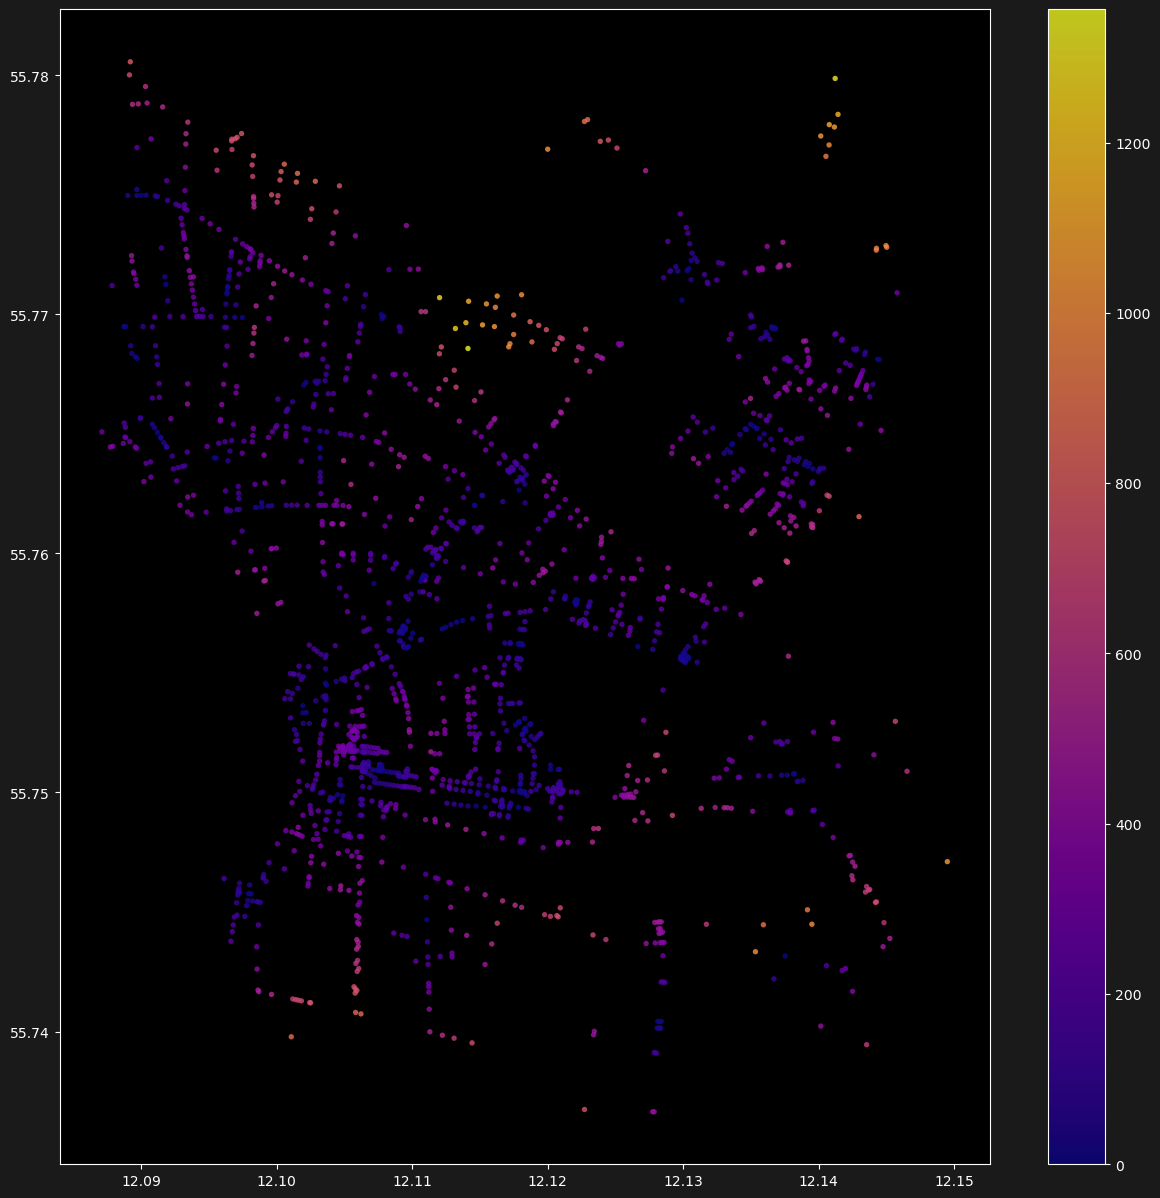

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot distance to nearest restaurant
# Set dark background style
plt.style.use('dark_background')

# Plot distance to nearest restaurant using Pandana's plot method
network.plot(
    nearest_restaurants[1],  # Distance to 1st nearest restaurant
    bbox=copenhagen_bbox,
    fig_kwargs={'figsize': (15, 15), 'facecolor': '#1a1a1a'},
    plot_kwargs={
        'cmap': 'plasma',         # Works well on dark backgrounds
        's': 15,
        'edgecolor': 'none',
        'alpha': 0.8
    },
)
plt.tight_layout()
plt.show()

### Square Footage within 500m

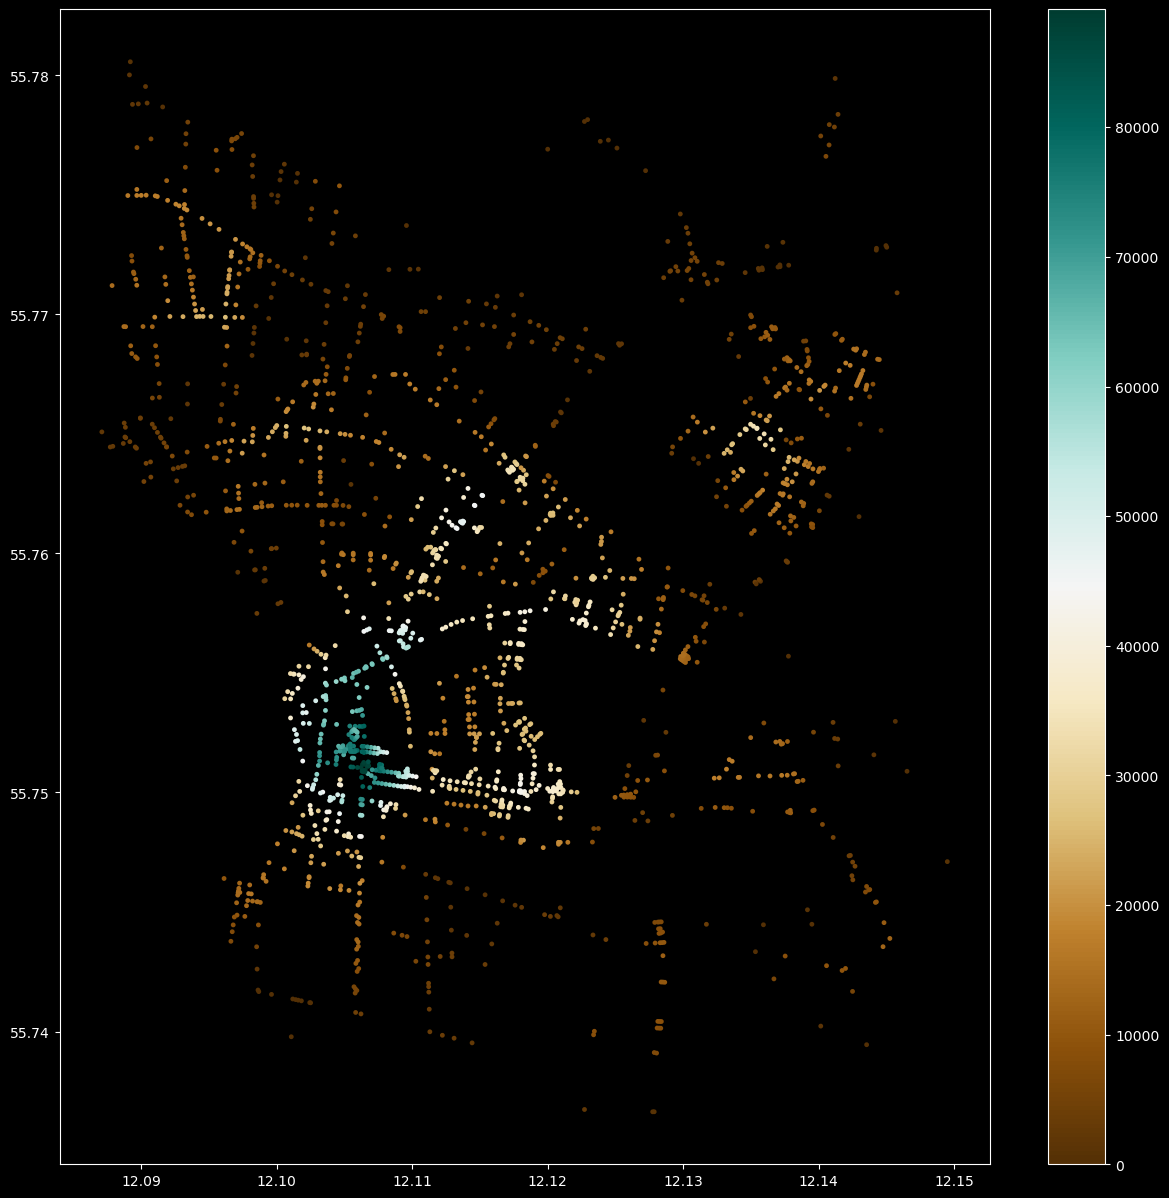

In [31]:
# Plot square footage aggregation at 500m
network.plot(
    sqft_500m,
    bbox=copenhagen_bbox,
    fig_kwargs={'figsize': [15, 15]},
    plot_kwargs={'cmap': 'BrBG', 's': 12, 'edgecolor': 'none'}
)
plt.show()

### Average Residential Units

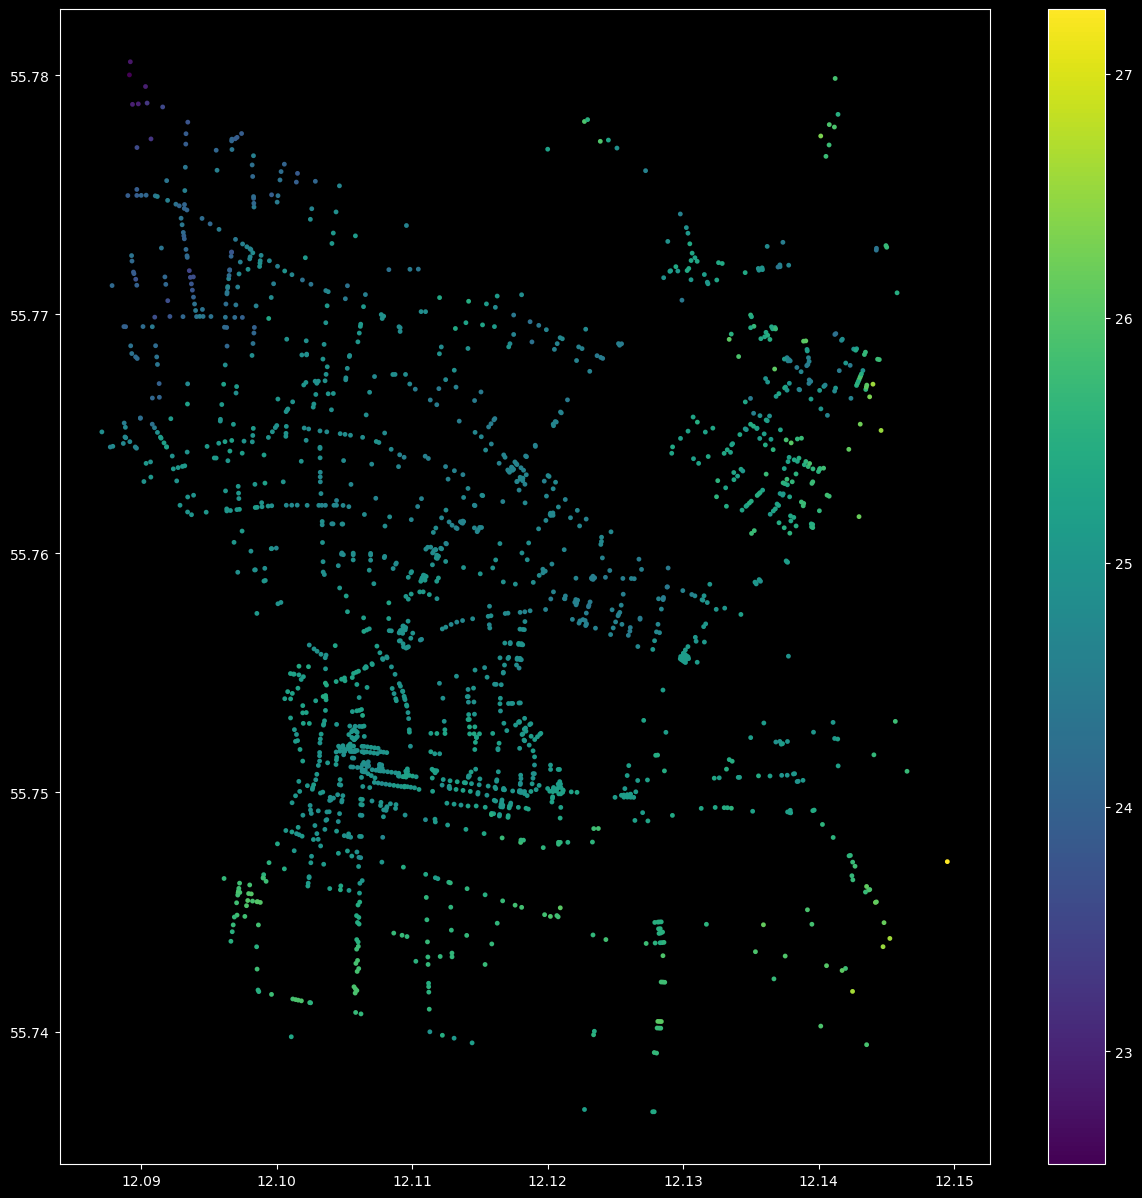

(<Figure size 1500x1500 with 2 Axes>, <Axes: >)

In [32]:
# Plot average residential units
network.plot(
    units_avg,
    bbox=copenhagen_bbox,
    fig_kwargs={'figsize': [15, 15]},
    plot_kwargs={'cmap': 'viridis', 's': 12, 'edgecolor': 'none'}
)


## 6. Customizing Plot Parameters

The `network.plot()` method accepts several parameter dictionaries:

- **`fig_kwargs`**: Figure size and other figure parameters
- **`plot_kwargs`**: Scatter plot parameters (colormap, point size, edge colors)

Common colormaps:
- `'BrBG'` - Brown to Blue-Green (diverging)
- `'RdYlGn'` - Red-Yellow-Green (diverging)
- `'YlOrRd'` - Yellow-Orange-Red (sequential)
- `'viridis'` - Perceptually uniform (sequential)

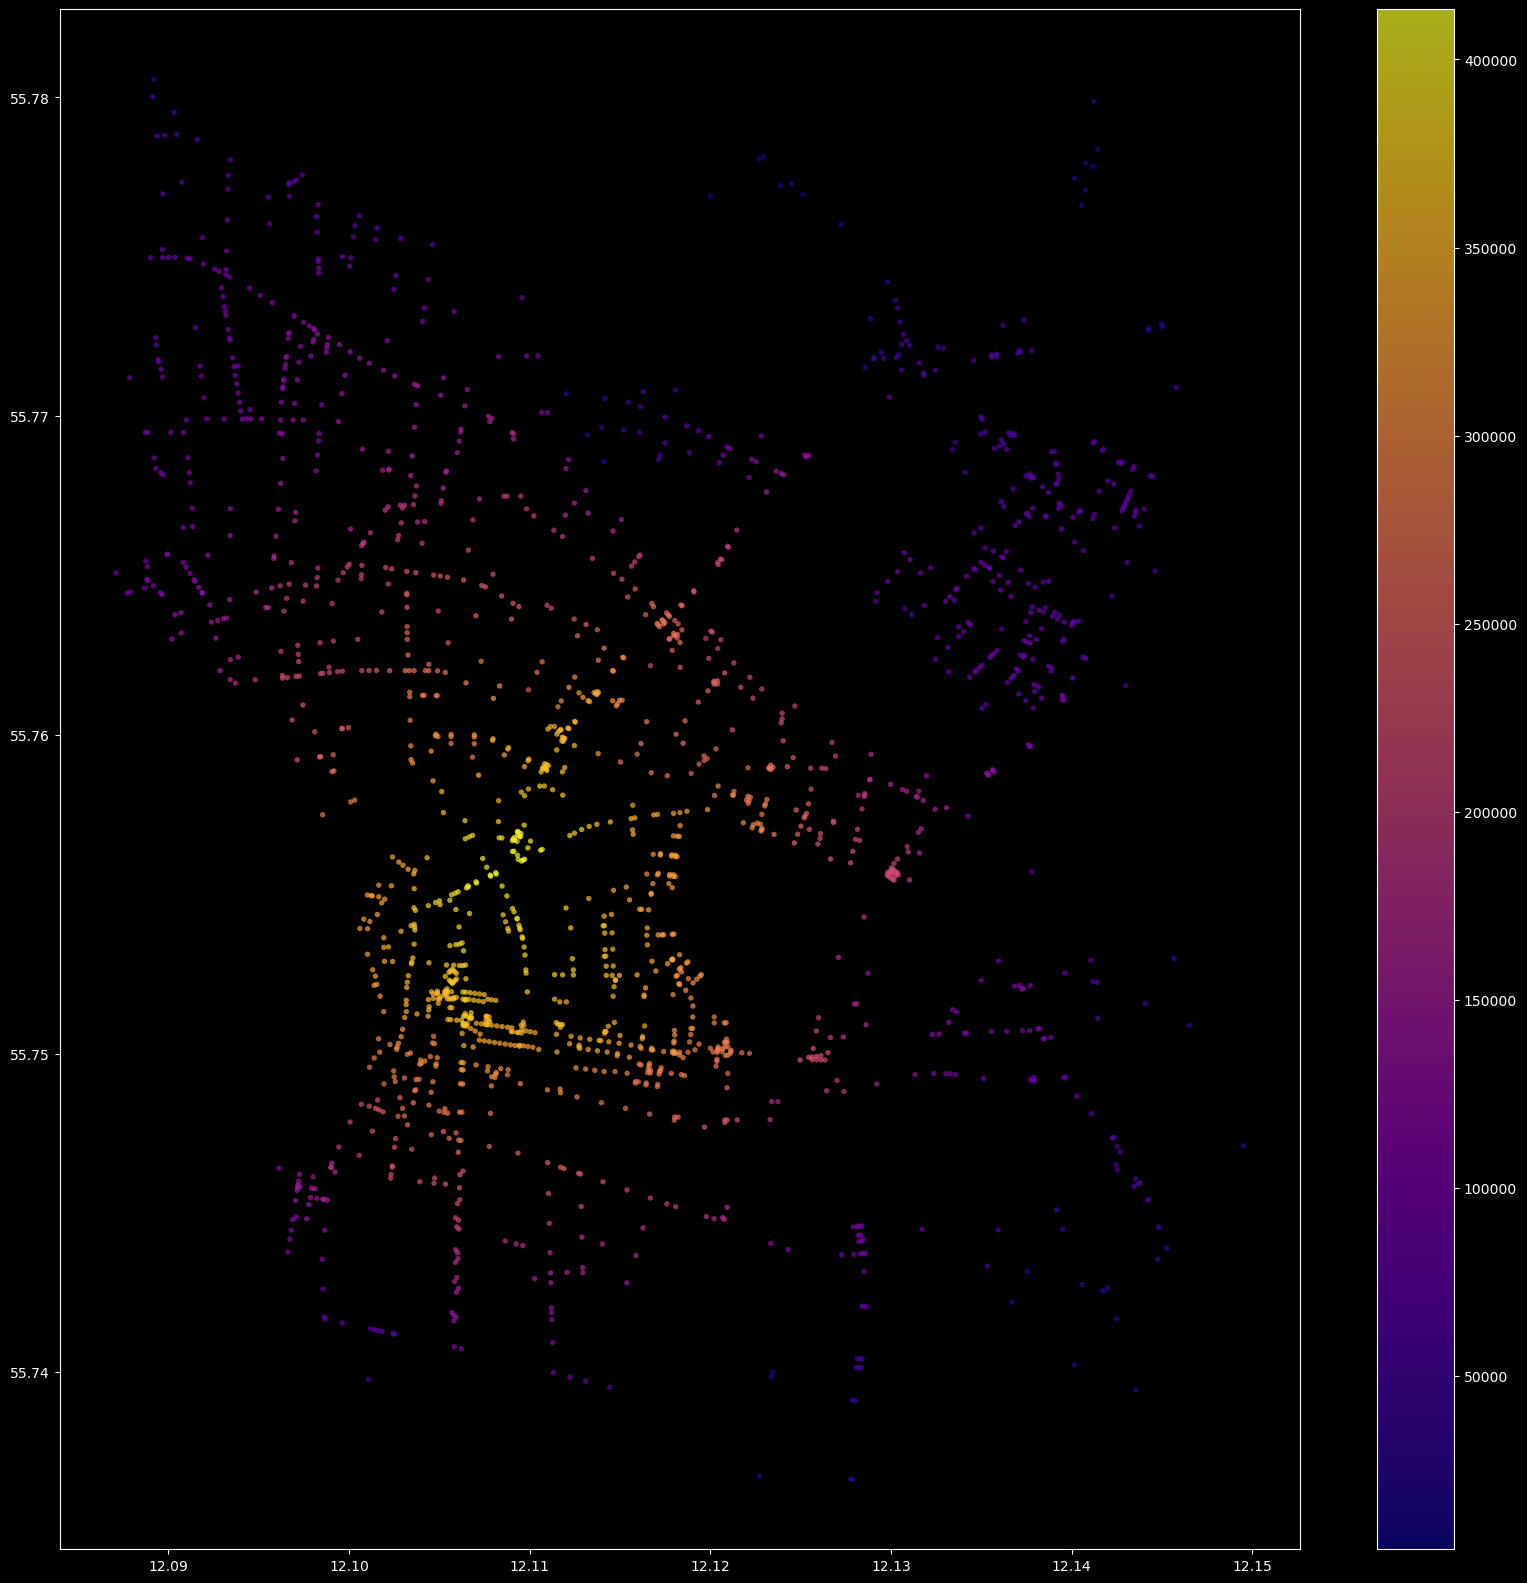

In [33]:
# Example with custom parameters
network.plot(
    sqft_2000m,
    bbox=copenhagen_bbox,
    fig_kwargs={'figsize': [20, 20]},

    plot_kwargs={
        'cmap': 'plasma',      # Different colormap
        's': 15,               # Larger points
        'edgecolor': 'none',   # No edges
        'alpha': 0.7           # Semi-transparent
    }
)

plt.show()

## Summary

This notebook demonstrated the complete Pandana workflow using the built-in `plot()` method:

1. **Network Creation**: Downloaded OSM street network for Copenhagen
2. **Precomputation**: Built routing tables for fast queries (up to 3000m)
3. **POI Queries**: Found distances to nearest restaurants from all network nodes
4. **Aggregations**: Calculated total/average values within different network distances
5. **Visualization**: Used `network.plot()` with bounding boxes for efficient display

### Key Features of `network.plot()`:

- **Bounding box support**: Focus on specific areas for better performance
- **Customizable parameters**: Control figure size, colormaps, and point appearance
- **Built-in basemap**: Automatic coordinate system handling
- **Fast rendering**: Optimized for large networks


In [34]:
# Final summary statistics
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)
print(f"\nNetwork: {len(network.nodes_df):,} nodes, {len(network.edges_df):,} edges")
print(f"POIs analyzed: {num_restaurants} restaurants")
print(f"Buildings analyzed: {num_buildings} buildings")
print(f"Bounding box: {copenhagen_bbox}")
print("\n" + "="*70)
print("All visualizations created using network.plot() method")
print("="*70)

ANALYSIS SUMMARY

Network: 1,814 nodes, 2,450 edges
POIs analyzed: 50 restaurants
Buildings analyzed: 200 buildings
Bounding box: [55.73939, 12.08625, 55.78072, 12.14461]

All visualizations created using network.plot() method
